In [1]:
from toolz import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
# %matplotlib widget


import pathlib
from lenses import lens

from collections import Counter

import re
import nltk
import pymorphy2
import fasttext.util

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

import pickle

2023-02-15 15:56:07.563268: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 15:56:07.837482: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-15 15:56:07.897398: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-15 15:56:07.897430: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
lmap = compose(list, map)
ltake = compose(list, take)

In [4]:
data_path = pathlib.Path('data')

### Загружаем из pickle

In [41]:
with data_path.joinpath('processed_data_dict.pkl').open(mode='rb') as f:
    pickled_data = pickle.load(f)

df_for_learning             = pickled_data['df_for_learning']
all_courses                 = pickled_data['all_courses']
all_cuisines                = pickled_data['all_cuisines']
word_embeddings_dict        = pickled_data['word_embeddings_dict']
ingredients_numbering_dict  = pickled_data['ingredients_numbering_dict']
dim                         = pickled_data['dim']
ingredients_lemmatized      = pickled_data['ingredients_lemmatized']
all_ingredients_list        = pickled_data['all_ingredients_list']
ingredients_embeddings_dict = pickled_data['ingredients_embeddings_dict']
# tfidf                       = pickled_data['tfidf']

pickled_data.keys()

dict_keys(['df_for_learning', 'all_courses', 'all_cuisines', 'word_embeddings_dict', 'ingredients_numbering_dict', 'dim', 'ingredients_lemmatized', 'all_ingredients_list', 'ingredients_embeddings_dict'])

## Подготовка BoE

In [34]:
data = np.array(list(df_for_learning['ingredient_embedding']))
labels = to_categorical(np.array(df_for_learning['course_mark']), num_classes=len(all_courses))

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

VALIDATION_SPLIT = 0.2
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

## Обучение BoE

In [35]:
sequence_input = layers.Input(shape=(dim,), dtype='int32')
x = layers.Dense(64, activation='relu')(sequence_input)
x = layers.Dense(16, activation='relu')(x)
preds = layers.Dense(len(all_courses), activation='softmax')(x)

model = keras.Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 302)]             0         
                                                                 
 dense_3 (Dense)             (None, 64)                19392     
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 9)                 153       
                                                                 
Total params: 20,585
Trainable params: 20,585
Non-trainable params: 0
_________________________________________________________________


In [21]:
EPOCHS = 20
H = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=EPOCHS, batch_size=128)

Epoch 1/20
259/259 [==============================] - 1s 2ms/step - loss: 1.5757 - accuracy: 0.4659 - val_loss: 1.4329 - val_accuracy: 0.4983
Epoch 2/20
259/259 [==============================] - 0s 1ms/step - loss: 1.3975 - accuracy: 0.5087 - val_loss: 1.3785 - val_accuracy: 0.5141
Epoch 3/20
259/259 [==============================] - 0s 1ms/step - loss: 1.3509 - accuracy: 0.5201 - val_loss: 1.3438 - val_accuracy: 0.5185
Epoch 4/20
259/259 [==============================] - 0s 1ms/step - loss: 1.3276 - accuracy: 0.5269 - val_loss: 1.3333 - val_accuracy: 0.5241
Epoch 5/20
259/259 [==============================] - 0s 1ms/step - loss: 1.3099 - accuracy: 0.5303 - val_loss: 1.3268 - val_accuracy: 0.5241
Epoch 6/20
259/259 [==============================] - 0s 1ms/step - loss: 1.2976 - accuracy: 0.5341 - val_loss: 1.3208 - val_accuracy: 0.5287
Epoch 7/20
259/259 [==============================] - 0s 1ms/step - loss: 1.2878 - accuracy: 0.5379 - val_loss: 1.3147 - val_accuracy: 0.5293
Epoch 

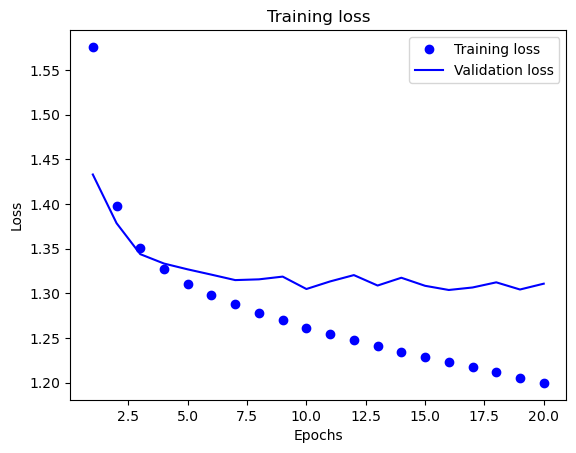

In [23]:
loss = H.history['loss'] 
val_loss = H.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

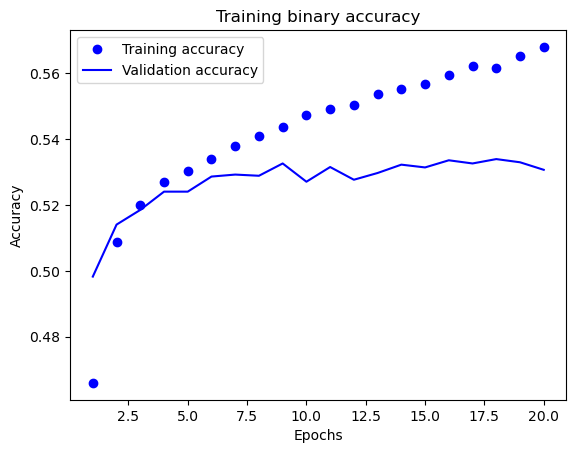

In [24]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training binary accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Подготовка к CNN

In [36]:
data = lens.Each().Each().modify(lambda x: ingredients_numbering_dict[x])(ingredients_lemmatized)

In [37]:
data[:2]

[[4142, 1075, 3364, 4215], [2493, 1611, 3066, 3961, 433]]

In [38]:
data = pad_sequences(data, padding='post', value=0)
labels = to_categorical(np.array(df_for_learning['course_mark']), num_classes=len(all_courses))

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

VALIDATION_SPLIT = 0.2
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [39]:
max_length = len(data[0])
max_length

40

In [42]:
#Эта матрица будет использоваться для слоя Embedding в keras
ingredients_embeddings_matrix = np.zeros((len(all_ingredients_list), dim))
ingredients_embeddings_matrix.shape
for ingr in all_ingredients_list:
    ingredients_embeddings_matrix[ingredients_numbering_dict[ingr]] = ingredients_embeddings_dict[ingr]
ingredients_embeddings_matrix.shape

(4406, 302)

## Обучение CNN

In [43]:
embedding_layer = layers.Embedding(len(ingredients_embeddings_dict),
                            dim,
                            weights=[ingredients_embeddings_matrix],
                            input_length=max_length,
                            trainable=False)
# trainable=True позволит до обучаться эмбеддингам на нашем датасете

In [44]:
#первая архитектура CNN
# sequence_input = layers.Input(shape=(max_length,), dtype='int32')
# embedded_sequences = embedding_layer(sequence_input)
# x = layers.Conv1D(64, 2, activation='relu')(embedded_sequences)
# x = layers.GlobalMaxPool1D()(x)
# x = layers.Flatten()(x)
# x = layers.Dense(32, activation='relu')(x)
# preds = layers.Dense(len(all_courses), activation='softmax')(x)

#вторая архитектура CNN
sequence_input = layers.Input(shape=(max_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
arr = []
for i in [2,3,4]:
    x = layers.Conv1D(64, i, activation='relu')(embedded_sequences)
    arr.append(layers.GlobalMaxPool1D()(x))

x = layers.Concatenate()(arr)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
preds = layers.Dense(len(all_courses), activation='softmax')(x)



model = keras.Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



In [45]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 302)      1330612     ['input_4[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 39, 64)       38720       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 38, 64)       58048       ['embedding[0][0]']              
                                                                                            

In [46]:
H = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=20, batch_size=128)

Epoch 1/20
259/259 [==============================] - 5s 16ms/step - loss: 1.2317 - accuracy: 0.5666 - val_loss: 1.0284 - val_accuracy: 0.6310
Epoch 2/20
259/259 [==============================] - 4s 16ms/step - loss: 0.9476 - accuracy: 0.6618 - val_loss: 0.8893 - val_accuracy: 0.6857
Epoch 3/20
259/259 [==============================] - 4s 16ms/step - loss: 0.8473 - accuracy: 0.6977 - val_loss: 0.8341 - val_accuracy: 0.6981
Epoch 4/20
259/259 [==============================] - 4s 16ms/step - loss: 0.7814 - accuracy: 0.7228 - val_loss: 0.8282 - val_accuracy: 0.7003
Epoch 5/20
259/259 [==============================] - 4s 16ms/step - loss: 0.7390 - accuracy: 0.7366 - val_loss: 0.7850 - val_accuracy: 0.7151
Epoch 6/20
259/259 [==============================] - 4s 16ms/step - loss: 0.7018 - accuracy: 0.7491 - val_loss: 0.8320 - val_accuracy: 0.7042
Epoch 7/20
259/259 [==============================] - 4s 16ms/step - loss: 0.6669 - accuracy: 0.7626 - val_loss: 0.8137 - val_accuracy: 0.7146

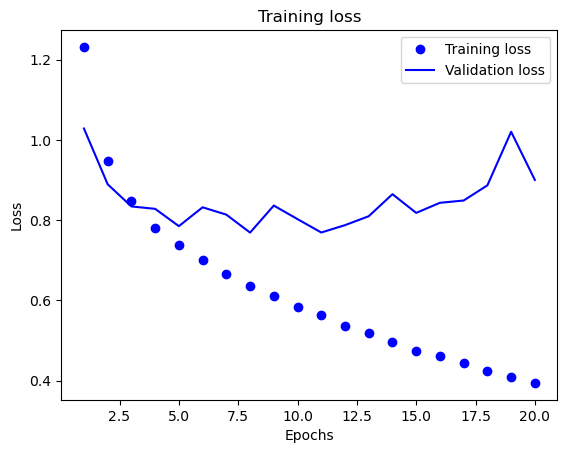

In [47]:
loss = H.history['loss'] 
val_loss = H.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

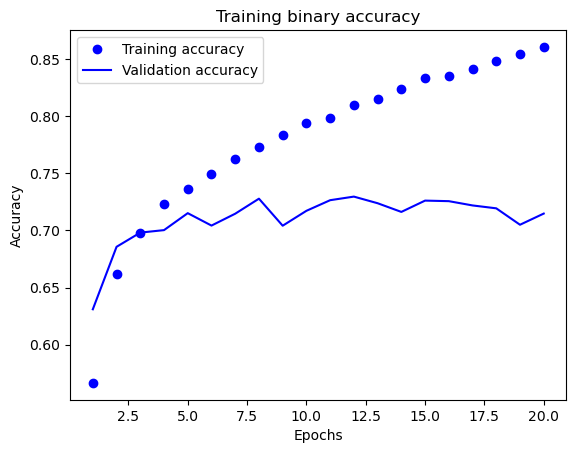

In [48]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training binary accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
a = ft.get_word_vector('кокосовый')-ft.get_word_vector('кокосовое')+ft.get_word_vector('кремовое')-ft.get_word_vector('кремовый')
a@a

NameError: name 'ft' is not defined